<a href="https://colab.research.google.com/github/LoPA607/SOC-2024/blob/main/week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install einops
import einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00


In [ ]:
import random
import imageio
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import Compose,ToTensor,Lambda
from torchvision.datasets.mnist import MNIST
from tqdm.auto import tqdm
from argparse import ArgumentParser
import einops

In [ ]:
SEED=0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

STORE_PATH_MNIST=f"ddpm_model_mnist.pt"

In [ ]:

#parameters
no_train=False
batch_size=128
epochs=50
lr=0.001
store_path="ddpm_mnist.pt"

In [ ]:
def load_first_batch(loader):
  for batch in loader:
    load_images(batch[0],"IMAGES of first batch")
    break

In [ ]:
def load_images(images, title=""):
  if type(images) is torch.Tensor:
    images=images.detach().cpu().numpy()
  fig=plt.figure(figsize=(10,10))
  rows=int(len(images)**0.5)
  cols=round(len(images)/rows)
  idx=0
  for i in range(rows):
    for j in range(cols):
      fig.add_subplot(rows,cols,idx+1)

      if idx<len(images):
        plt.imshow(images[idx][0],cmap="gray")
        idx=idx+1
  fig.suptitle(title,fontsize=25)
  plt.show()

In [ ]:

#NORMALISE images
transform=Compose([
    ToTensor(),
    Lambda(lambda x:(x-0.5)*2)
])
ds_fn=MNIST
dataset=ds_fn("./datasets", download=True, transform=transform)
loader=DataLoader(dataset, batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17566716.99it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 486834.79it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4367190.37it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9979323.61it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



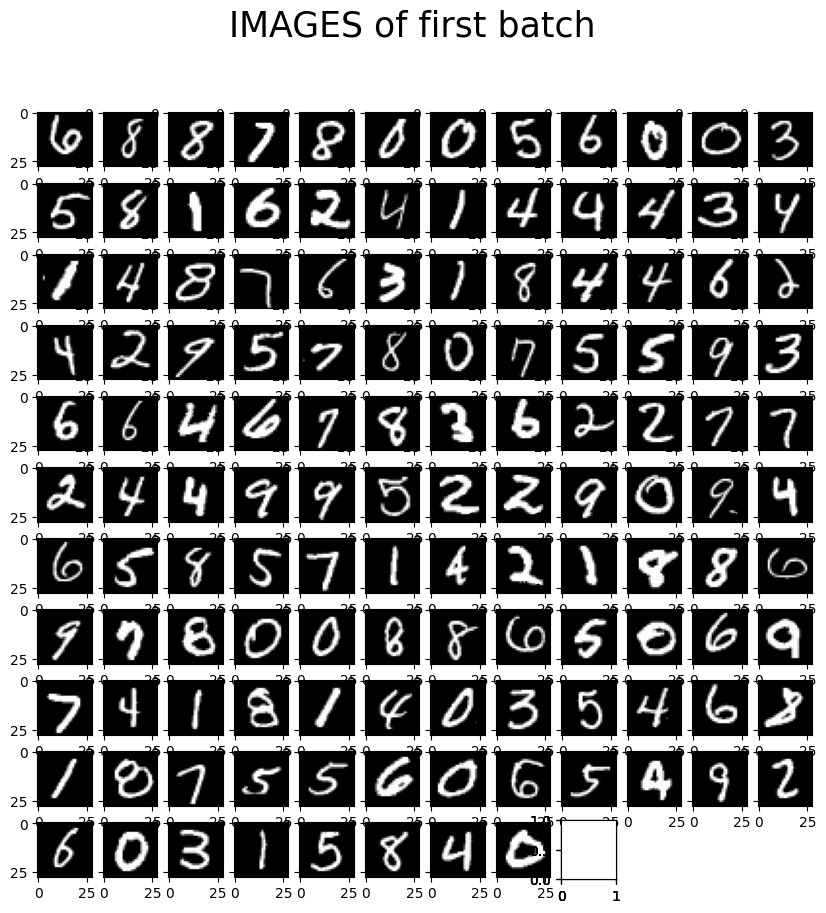

In [ ]:
load_first_batch(loader)

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using devie: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using devie: cuda	Tesla T4


In [ ]:
#DDPM
class DDPM(nn.Module):
  def __init__(self, network, n_steps=200,min_beta=10 ** -4,max_beta=0.02, device=None, image_chw=(1,28,28)):
    super(DDPM, self).__init__()
    self.n_steps=n_steps
    self.min_beta=min_beta
    self.max_beta=max_beta
    self.device=device
    self.image_chw=image_chw
    self.device=device
    self.image_chw=image_chw
    self.network=network.to(device)
    self.betas=torch.linspace(min_beta, max_beta, n_steps).to(device)
    self.alpha=1-self.betas
    self.alpha_bars=torch.tensor([torch.prod(self.alpha[:i+1]) for i in range(len(self.alpha))]).to(device)

  def forward(self, x0, t, eta=None):
    n,c,h,w=x0.shape
    a_bar=self.alpha_bars[t]

    if eta is None:
      eta=torch.randn(n,c,h,w).to(self.device)

    noisy=a_bar.sqrt().reshape(n,1,1,1)*x0+(1-a_bar).sqrt().reshape(n,1,1,1)*eta
    return noisy

  def backward(self, x, t):
    return self.network(x,t)

In [ ]:
#Sampling
def show_forward(ddpm, loader, device):
  for batch in loader:
    imgs=batch[0]

    load_images(imgs, "Original Images")

    for i in [0.25,0.5,0.75,1]:
      load_images(
          ddpm(imgs.to(device),
               [int(i*ddpm.n_steps)-1 for _ in range(len(imgs))]),
          f"DDPM Noise Images {int(i*100)}%"
      )
      break

In [ ]:
#Generate new images
def generate_images(ddpm, n_samples=16,device=None,frames_per_gif=100, gif_name="sampling.gif", c=1,h=28,w=28):
  frame_idxs=np.linspace(0,ddpm.n_steps,frames_per_gif).astype(np.uint)
  frames=[]

  with torch.no_grad():
    if device is None:
      device=ddpm.device

    x=torch.randn(n_samples,c,h,w).to(device)

    for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
      time_tensor=(torch.ones(n_samples,1)*t).to(device).long()
      eta_theta=ddpm.backward(x, time_tensor)

      alpha_t=ddpm.alpha[t]
      alpha_t_bar=ddpm.alpha_bars[t]

      x=(1/alpha_t.sqrt())*(x-(1-alpha_t)/(1-alpha_t_bar).sqrt()*eta_theta)
      if t>0:
        z=torch.randn(n_samples,c,h,w).to(device)
        beta_t=ddpm.betas[t]
        sigma_t=beta_t.sqrt()
        x=x+sigma_t*z

      if idx in frame_idxs or t==0:
        normalized=x.clone()
        for i in range(len(normalized)):
          normalized[i]-=torch.min(normalized[i])
          normalized[i]*=255/torch.max(normalized[i])

        normalized_rgb=torch.cat([normalized,normalized,normalized],dim=1)

        frame=einops.rearrange(normalized_rgb, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples**0.5))
        frame=frame.cpu().numpy().astype(np.uint8)
        frames.append(frame)

    with imageio.get_writer(gif_name, mode="I") as writer:
      for idx,frame in enumerate(frames):
        writer.append_data(frame)
        if idx== len(frames)-1:
          for _ in range(frames_per_gif // 3):
            writer.append_data(frames[-1])
  return x

In [ ]:
class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(Block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [ ]:
def sinusoidal_embedding(n,d):
  embedding=torch.zeros(n,d)
  wk=torch.tensor([1/10000 ** (2*k/d) for k in range(d)])
  wk=wk.reshape((1,d))
  t=torch.arange(n).reshape((n,1))
  embedding[:,::2] = torch.sin(t * wk[:,::2])
  embedding[:,1::2] = torch.cos(t * wk[:,::2])

  return embedding


In [ ]:
def _make_te(self, dim_in, dim_out):
  return nn.Sequential(
    nn.Linear(dim_in, dim_out),
    nn.SiLU(),
    nn.Linear(dim_out, dim_out)
  )

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(UNet, self).__init__()


        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        #first
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            Block((1, 28, 28), 1, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            Block((10, 14, 14), 10, 20),
            Block((20, 14, 14), 20, 20),
            Block((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            Block((20, 7, 7), 20, 40),
            Block((40, 7, 7), 40, 40),
            Block((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            Block((40, 3, 3), 40, 20),
            Block((20, 3, 3), 20, 20),
            Block((20, 3, 3), 20, 40)
        )

        # Second
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            Block((80, 7, 7), 80, 40),
            Block((40, 7, 7), 40, 20),
            Block((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            Block((40, 14, 14), 40, 20),
            Block((20, 14, 14), 20, 10),
            Block((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            Block((20, 28, 28), 20, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):

        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))
        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))

        out5 = torch.cat((out2, self.up2(out4)), dim=1)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))

        out = torch.cat((out1, self.up3(out5)), dim=1)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
n_steps, min_beta, max_beta=1000, 10 ** -4,0.02
ddpm=DDPM(UNet(n_steps), n_steps=n_steps,min_beta=min_beta, max_beta=max_beta, device=device)

In [ ]:

def train_loop(ddpm, loader,epochs,optim,device,display=False,store_path="ddpm_model.pt"):
  mse=nn.MSELoss()
  best_loss=float("inf")
  n_steps=ddpm.n_steps
  for epoch in tqdm(range(epochs), desc=f"Training epochs", colour="red"):
    epoch_loss=0.0
    for step, batch in enumerate(tqdm(loader, leave=False, desc="Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
      x0=batch[0].to(device)
      n= len(x0)

      eta=torch.randn_like(x0).to(device)
      t=torch.randint(0,n_steps,(n,)).to(device)
      noisy_imgs=ddpm(x0,t,eta)
      eta_theta=ddpm.backward(noisy_imgs, t.reshape(n,-1))
      loss=mse(eta_theta,eta)
      optim.zero_grad()
      loss.backward()
      optim.step()
      epoch_loss+=loss.item()*len(x0)/len(loader.dataset)

    if display:
      load_images(generate_images(ddpm, device=device),f"Images generated at epoch {epoch + 1}")

    log_string=f"Loss at epoch {epoch+1}: {epoch_loss:.3f}"

    if best_loss>epoch_loss:
      best_loss=epoch_loss
      torch.save(ddpm.state_dict(),store_path)
      log_string+=" --> Best model ever (stored)"

    print(log_string)



In [19]:
store_path = "ddpm_mnist.pt"
if not no_train:
    train_loop(ddpm, loader, epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 0.171 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 0.049 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 0.042 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 0.040 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 0.038 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 0.036 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 0.035 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 0.034 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 0.034 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 0.033 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 0.033 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 0.032 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 0.032


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 0.032


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 0.031 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 0.031 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 0.031


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 0.030 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 0.030 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 0.030 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 21: 0.030 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 22: 0.029 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 23: 0.030


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 24: 0.029 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 25: 0.029


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 26: 0.029 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 27: 0.029


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 28: 0.028 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 29: 0.028


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 30: 0.028 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 31: 0.028


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 32: 0.028


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 33: 0.028 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 34: 0.028 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 35: 0.028


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 36: 0.028


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 37: 0.028


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 38: 0.028


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 39: 0.028


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 40: 0.027 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 41: 0.028


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 42: 0.027 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 43: 0.027


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 44: 0.027


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 45: 0.027 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 46: 0.027 --> Best model ever (stored)


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 47: 0.027


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 48: 0.027


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 49: 0.027


Epoch {epoch + 1}/{n_epochs}:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 50: 0.027


In [20]:
model=DDPM(UNet(),n_steps=n_steps, device=device)
model.load_state_dict(torch.load(store_path, map_location=device))
model.eval()
print("Model loaded")

Model loaded


Generating new images


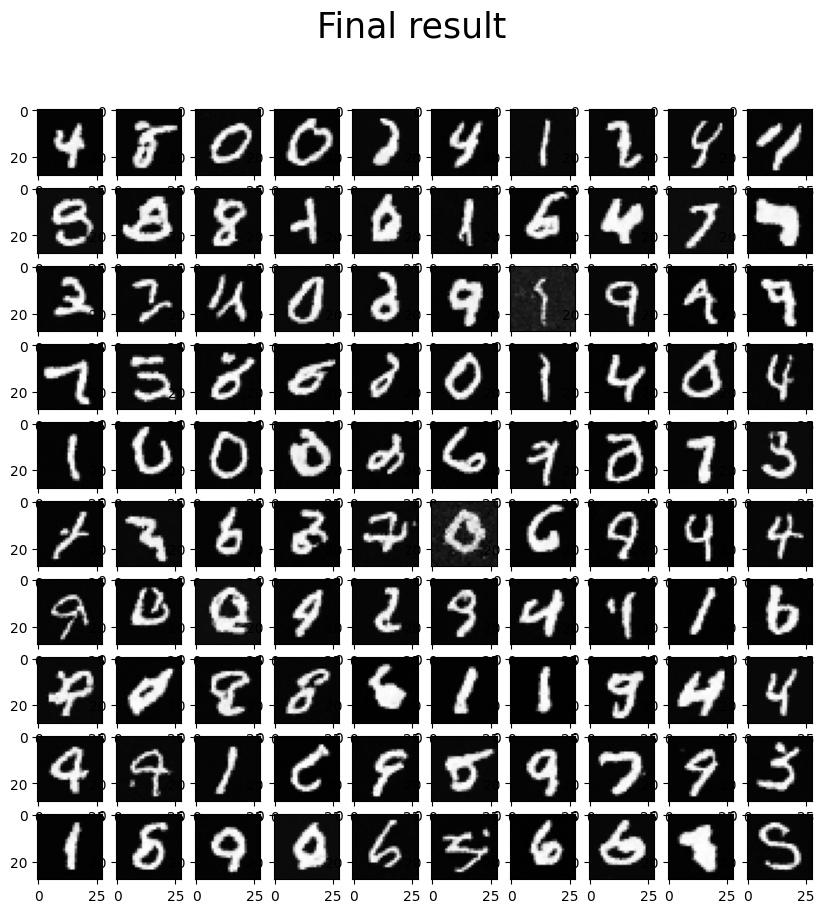

In [21]:
print("Generating new images")
generated = generate_images(
        model,
        n_samples=100,
        device=device,
        gif_name="mnist.gif"
    )
load_images(generated, "Final result")